## Applied on PHS

In [1]:
import numpy as np
#import tensorflow as tf
from matplotlib import pyplot as plt
import glob
import random


In [2]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

## HS Profiles

In [3]:
path3="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Eventcode/new_profile_singlePHS_projection/samples/"
hs_profile = np.load(path3+"Nside1024_singleHS_profile.npy")

# h(x) -> h(k)
h_frame = np.zeros( ( 360  ,  360 )) # Frame with zeros
h_frame[0:len(hs_profile),0:len(hs_profile)]+= hs_profile
np_rfft_hk=np.fft.rfft2(h_frame)


## Quicklens Map

In [4]:
path="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/quicklens_90x90_uncuts/"
#tot = np.load(path+"1PHS6Events_Nside2048_d0_d80_BKG_"+str(0)+".npy")

nx = 360
ny = 360
bkgs = np.empty(( 0,  ny, nx  ))
bkgs_uncut = np.empty(( 0,  ny, nx  ))

for nums in range(1):
    temp = np.load(path+'500_events_360Sqr_lensed_cutBackgroundlmax3500_'+str(nums)+'.npy')
    bkgs = np.concatenate((bkgs, temp))
    
    temp2 = np.load(path+'500_events_360Sqr_lensed_uncutBackgroundlmax3500_'+str(nums)+'.npy')
    bkgs_uncut = np.concatenate((bkgs_uncut, temp2))

In [5]:
cut_test = np.load(path+'500_events_360Sqr_lensed_cutBackgroundlmax3500_1.npy')
uncut_test = np.load(path+'500_events_360Sqr_lensed_uncutBackgroundlmax3500_1.npy')

In [6]:
np_rfft_dim = np.fft.rfft2(bkgs[0]).shape

In [7]:
# FFT average of multiple Backgrounds
fft_power = np.zeros((np_rfft_dim[0],np_rfft_dim[1]))
fft_power_uncut = np.zeros((np_rfft_dim[0],np_rfft_dim[1]))

#fft_power = np.zeros((420,420))
for evnt in range(len(bkgs)):
    temp = bkgs[evnt]
    tempfft = np.fft.rfft2(temp)
    temppower = tempfft*np.conj(tempfft)
    fft_power = fft_power + temppower
    
    temp2 = bkgs_uncut[evnt]
    temp2fft = np.fft.rfft2(temp2)
    temp2power = temp2fft*np.conj(temp2fft)
    fft_power_uncut = fft_power_uncut + temp2power
    if not (evnt+1) % 500:
        print(str(evnt+1))
        
fft_power = np.real(fft_power)/len(bkgs)
fft_power_uncut = np.real(fft_power_uncut)/len(bkgs_uncut)

500


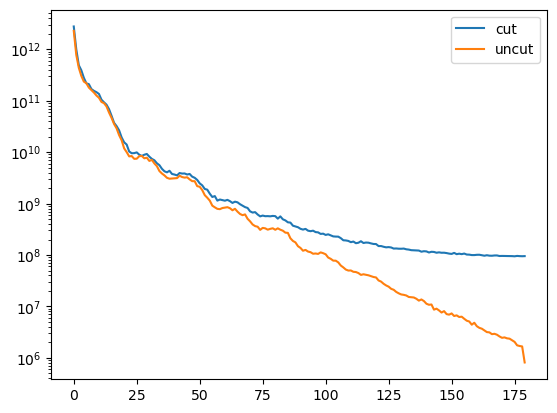

In [8]:
plt.plot(fft_power[0,1:],label='cut')
plt.plot(fft_power_uncut[0,1:],label='uncut')
plt.yscale('log')
plt.legend()

In [9]:
print(np.diag(fft_power).shape)
lengthdiag = np.sqrt(2)*np.arange(181)
length = np.arange(181)
length_off = np.sqrt(np.arange(181)**2+ 26**2)

(181,)


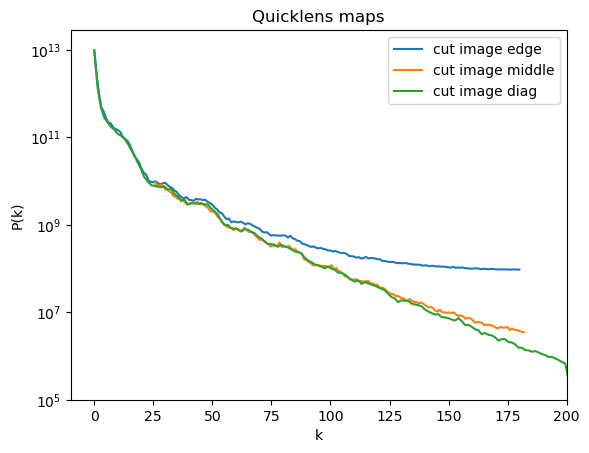

In [10]:
#plt.plot(length,length*(length+1)*fft_power[2],label = 'edge')
plt.plot(length,fft_power[0],label = 'cut image edge')
plt.plot(length_off,fft_power[27],label = 'cut image middle')
plt.plot(lengthdiag,np.diag(fft_power),label = 'cut image diag')

plt.title('Quicklens maps')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.ylim(10**5, )
plt.xlim(-10,200)
plt.legend()
plt.savefig("power_spectrum/Pk_quicklens_cut.pdf",bbox_inches='tight')

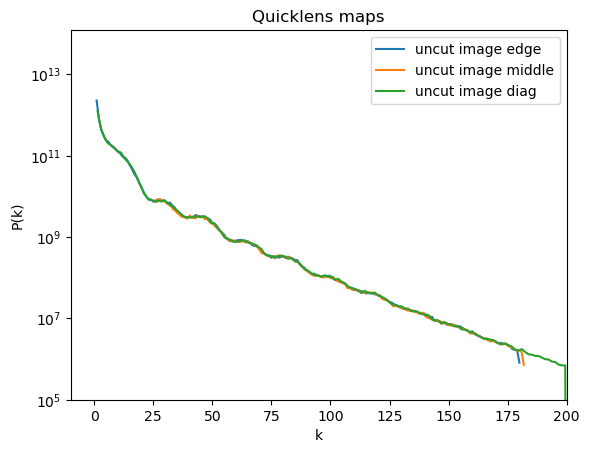

In [11]:
#plt.plot(length,length*(length+1)*fft_power[2],label = 'edge')
plt.plot(length[1:],fft_power_uncut[0][1:],label = 'uncut image edge')
plt.plot(length_off[1:],fft_power_uncut[27][1:],label = 'uncut image middle')
plt.plot(lengthdiag[1:],np.diag(fft_power_uncut)[1:],label = 'uncut image diag')

plt.title('Quicklens maps')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.ylim(10**5, )
plt.xlim(-10,200)
plt.legend()
plt.savefig("power_spectrum/Pk_quicklens_uncut.pdf",bbox_inches='tight')

In [9]:
#import pandas as pd
#pd.DataFrame(hpfft_power).to_csv("./healpy_Pk.csv")

In [10]:
# FFT on bkg
cut_bkg = []
uncut_bkg = []

for evnts in range(len(cut_test)):
    tempfft = np.fft.rfft2(cut_test[evnts])
    tempfft[0,0]=0
    fft_power[fft_power<10**-10]=10**20
    tempfiltered = np.fft.irfft2(tempfft    * np_rfft_hk/fft_power)
    cut_bkg.append(tempfiltered)

for evnts in range(len(uncut_test)):
    tempfft = np.fft.rfft2(uncut_test[evnts])
    tempfft[0,0]=0
    fft_power_uncut[fft_power_uncut<10**-10]=10**20
    tempfiltered = np.fft.irfft2(tempfft    * np_rfft_hk/fft_power_uncut)
    uncut_bkg.append(tempfiltered)


cut_bkg = np.array(cut_bkg)
uncut_bkg = np.array(uncut_bkg)

In [11]:
flat_cut_bkg = cut_bkg.flatten()
flat_uncut_bkg = uncut_bkg.flatten()

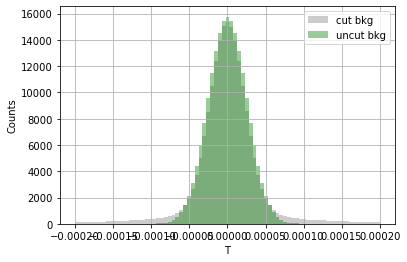

In [29]:
binsabs = np.linspace(-0.0002,0.0002,80)

n1, bins1, patches1 = plt.hist(flat_cut_bkg,binsabs,alpha = 0.4,color = 'grey',label = "cut bkg",density=True)
n2, bins2, patches2 = plt.hist(flat_uncut_bkg,binsabs,alpha = 0.4,color = 'g',label = "uncut bkg",density=True)

plt.legend()

plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [13]:
# FFT on bkg
cut_bkg_w_uncutPk = []

for evnts in range(len(cut_test)):
    tempfft = np.fft.rfft2(cut_test[evnts])
    tempfft[0,0]=0
    fft_power[fft_power<10**-10]=10**20
    tempfiltered = np.fft.irfft2(tempfft    * np_rfft_hk/fft_power_uncut)
    cut_bkg_w_uncutPk.append(tempfiltered)


cut_bkg_w_uncutPk = np.array(cut_bkg_w_uncutPk)

In [14]:
flat_cut_bkg_w_uncutPk = cut_bkg_w_uncutPk.flatten()

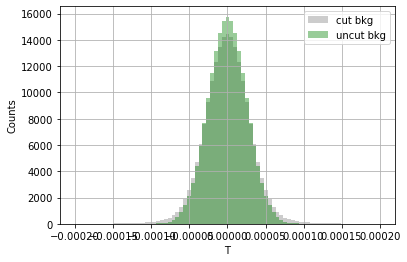

In [15]:
binsabs = np.linspace(-0.0002,0.0002,80)

n1, bins1, patches1 = plt.hist(flat_cut_bkg_w_uncutPk,binsabs,alpha = 0.4,color = 'grey',label = "cut bkg",density=True)
n2, bins2, patches2 = plt.hist(flat_uncut_bkg,binsabs,alpha = 0.4,color = 'g',label = "uncut bkg",density=True)

plt.legend()

plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

## Background Fitting

In [21]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [22]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

[4.83778068e-10 2.43563651e-05 1.48666726e+04]


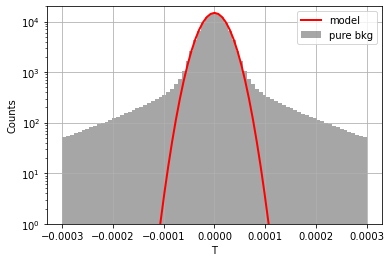

In [27]:
binsabs = np.linspace(-0.0003,0.0003,80)

n1, bins1, patches1 = plt.hist(flat_cut_bkg,binsabs,alpha = 0.7,color = 'grey',label = "pure bkg",density=True)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#         mu,sigma1,A
expected=(0.,0.00002,17000)
lowbound = 0
highbound = 60
params,cov=curve_fit(gauss,binsmid[lowbound:highbound],n1[lowbound:highbound],expected,maxfev=400000)
sigma=np.sqrt(np.diag(cov))

plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

print(params)

plt.legend()

plt.yscale('log')
plt.ylim(1, 20000)
#plt.xlim(binsmid[lowbound:highbound][0],binsmid[lowbound:highbound][-1])
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

[6.82972533e-11 2.52839821e-05 1.57799975e+04]


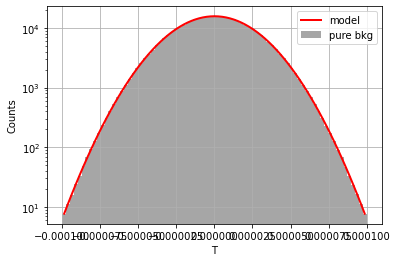

In [28]:
binsabs = np.linspace(-0.0001,0.0001,80)

n1, bins1, patches1 = plt.hist(flat_uncut_bkg,binsabs,alpha = 0.7,color = 'grey',label = "pure bkg",density=True)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#         mu,sigma1,A
expected=(0.,0.00002,17000)
lowbound = 0
highbound = 60
params,cov=curve_fit(gauss,binsmid[lowbound:highbound],n1[lowbound:highbound],expected,maxfev=400000)
sigma=np.sqrt(np.diag(cov))

plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

print(params)

plt.legend()

plt.yscale('log')
#plt.ylim(0, 40)
#plt.xlim(binsmid[lowbound:highbound][0],binsmid[lowbound:highbound][-1])
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [13]:
np.var(flat_qlfiltered_bkg)

6.335157266378585e-10

## Likelihood

In [15]:
def bkg_fit(x):
    return gauss(x,params[0],params[1],params[2])

bkg_likelihood = 0

# Chi Square Method

## g = 6

In [81]:
# FFT on planted signals
file_loc = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

# Load CMB signal only (g = 1)
CMB_sig = []
for file_num in range(1,3):
    Xtemp = np.load(file_loc+"PHS_signal/500_PHS_g1_Sig_"+str(file_num)+".npy")
    for k in range(Xtemp.shape[0]):
        CMB_sig.append(Xtemp[k])

CMB_sig = np.array(CMB_sig)

rescale_val = 4

In [82]:
#hpBkpSig = hpbkgs+PHSsig
cutBkpSig = cut_test[:500]+rescale_val*CMB_sig[:500]
uncutBkpSig = uncut_test[:500]+rescale_val*CMB_sig[:500]


cutBkpSigfilt = []
uncutBkpSigfilt = []


for evnts in range(500):
    cuttempfft = np.fft.rfft2(cutBkpSig[evnts])
    uncuttempfft = np.fft.rfft2(uncutBkpSig[evnts])
    
    cuttempfft[0,0]=0
    uncuttempfft[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    fft_power_uncut[fft_power_uncut<10**-20]=10**20
    
    cuttempfiltered = np.fft.irfft2(cuttempfft    * np_rfft_hk/fft_power)
    uncuttempfiltered = np.fft.irfft2(uncuttempfft    * np_rfft_hk/fft_power_uncut)
    

    cutBkpSigfilt.append(cuttempfiltered)
    uncutBkpSigfilt.append(uncuttempfiltered)
    

cutBkpSigfilt = np.array(cutBkpSigfilt)
uncutBkpSigfilt = np.array(uncutBkpSigfilt)

flat_cutBkpSigfilt = cutBkpSigfilt.flatten()
flat_uncutBkpSigfilt = uncutBkpSigfilt.flatten()

In [83]:
binsabs = np.linspace(-0.045,0.045,100)
#binsabs = np.linspace(-0.0002,0.0002,100)

thres = 37
n1max = 45

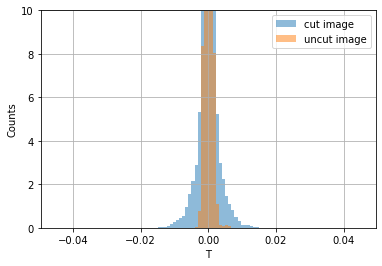

In [84]:
n2, bins2, patches2 = plt.hist(flat_cutBkpSigfilt,binsabs,alpha = 0.5,label = "cut image",density=True)

n2, bins2, patches2 = plt.hist(flat_uncutBkpSigfilt,binsabs,alpha = 0.5,label = "uncut image",density=True)

#n1, bins1, patches1 = plt.hist(flat_uncutBkpSigfilt,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

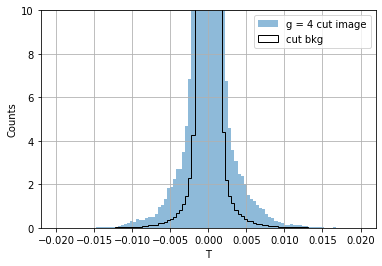

In [85]:
binsabs = np.linspace(-0.02,0.02,100)

n2, bins2, patches2 = plt.hist(flat_cutBkpSigfilt,binsabs,alpha = 0.5,label = f"g = {rescale_val} cut image",density=True)

n1, bins1, patches1 = plt.hist(flat_cut_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "cut bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

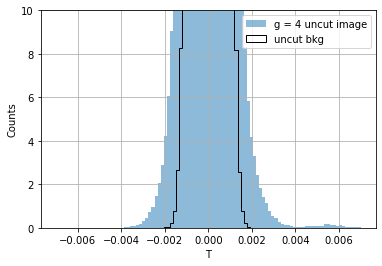

In [86]:
binsabs = np.linspace(-0.007,0.007,100)

n2, bins2, patches2 = plt.hist(flat_uncutBkpSigfilt,binsabs,alpha = 0.5,label = f"g = {rescale_val} uncut image",density=True)

n1, bins1, patches1 = plt.hist(flat_uncut_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "uncut bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [21]:
print(np.sum(n2))
print(np.sum(n1))

thres = 37
n1max = 45
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

123750.0
123749.99999999999
[  10.06614583   32.83003472   95.51762153  251.15329861  600.1875
 1290.07942708 2507.55694444 4396.78689236]
[  28.33113271   56.08361135  125.66915112  289.10168736  647.18161418
 1340.62690816 2557.45812938 4431.2011381 ]
d.o.f = 7


71.78649236574452

## g = 3

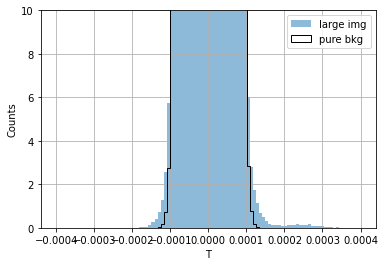

In [22]:
# FFT on planted signals
path2="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/sig_larger/"

PHSsignals = []
for batch in range(1,6):
    temp = np.load(path2+"30_PHS_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 3
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = qlbkgs[:500]+PHSsig[:,:360,:360]


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=True)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [23]:
print(np.sum(n2))
print(np.sum(n1))

thres = 37
n1max = 45
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

123750.0
123749.99999999999
[  10.06614583   32.83003472   95.51762153  251.15329861  600.1875
 1290.07942708 2507.55694444 4396.78689236]
[  14.82135417   39.90746528  106.46510417  267.03263889  622.90746528
 1315.34791667 2534.87743056 4419.05329861]
d.o.f = 7


7.796190539570652

## g = 2

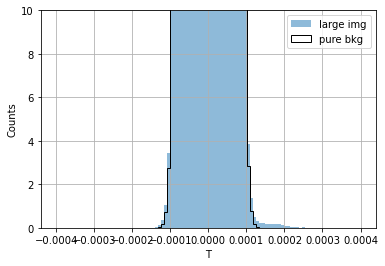

In [93]:
# FFT on planted signals
path2="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/sig_larger/"

PHSsignals = []
for batch in range(1,6):
    temp = np.load(path2+"30_PHS_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 2
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = qlbkgs[:500]+PHSsig[:,:360,:360]


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-10]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=True)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

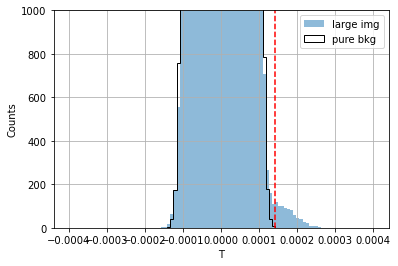

In [94]:
n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img")
n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg")

thres = 68
#n1max = 45

plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 1000)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [95]:
print(np.sum(n2[67:]))
print(np.sum(n1[67:]))

805.0
1.0


In [63]:
evntnum = 3
xloc = PHSsig_loc[evntnum][0,0]
yloc = PHSsig_loc[evntnum][0,1]

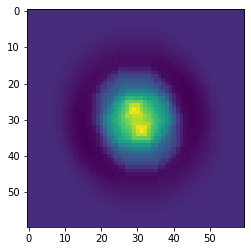

In [64]:
plt.imshow(PHSsig[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])

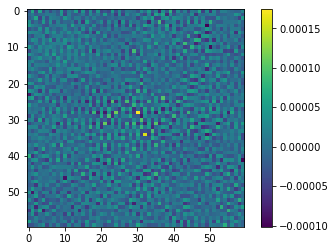

In [65]:
plt.imshow(qlBkpSigfilt[evntnum][xloc-30+25:xloc+30+25,yloc-30+25:yloc+30+25],cmap='viridis')
plt.colorbar()

In [75]:
print(np.sum(n2))
print(np.sum(n1))

thres = 30
n1max = 40
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

123749.99999999999
123749.99999999999
[0.00000000e+00 0.00000000e+00 4.77430556e-03 3.91493056e-02
 1.64236111e-01 7.24739583e-01 2.77291667e+00 1.00661458e+01
 3.28300347e+01 9.55176215e+01]
[7.63888889e-03 5.72916667e-03 3.05555556e-02 8.59375000e-02
 2.97916667e-01 1.04461806e+00 3.45468750e+00 1.14831597e+01
 3.50911458e+01 1.00365451e+02]
d.o.f = 9


/tmp/ipykernel_121002/4143925260.py:10: RuntimeWarning: divide by zero encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


inf

In [30]:
print(np.sum(n2))
print(np.sum(n1))

thres = 29
n1max = 37
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

123750.0
123749.99999999999
[0.         0.         0.         0.00477431 0.03914931 0.16423611
 0.72473958 2.77291667]
[0.         0.         0.         0.00381944 0.03628472 0.17951389
 0.73715278 2.84548611]
d.o.f = 7


/tmp/ipykernel_121002/2841332956.py:10: RuntimeWarning: invalid value encountered in true_divide
  np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])


nan

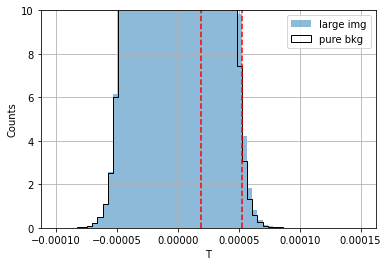

In [102]:
n2, bins2, patches2 = plt.hist(flat_hpBkpSigfilt,binsabs,alpha = 0.5,label = "large img",weights = 1/500*np.ones(len(flat_hpBkpSigfilt)))

n1, bins1, patches1 = plt.hist(flat_hpfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",weights = 1/500*np.ones(len(flat_hpBkpSigfilt)))

plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [103]:
print(np.sum(n2))
print(np.sum(n1))

thres = 21
n1max = 29
n2max = 50
print(n1[thres:n1max])
print(n2[thres:n1max])
print("d.o.f = "+str(len(n2[thres:n1max])-1))
np.sum((n2[thres:n1max]-n1[thres:n1max])**2/n1[thres:n1max])

129959.99599989917
129959.99599989917
[14055.008      17513.04200002 19028.84199999 18009.11599996
 14858.38599997 10707.39199997  6765.01199998  3768.76599999]
[14020.982      17390.66000002 18855.70599999 17843.30799996
 14765.05599997 10693.96199998  6816.47599998  3837.91799999]
d.o.f = 7


6.302893776528178

## Pure Signal Only Check

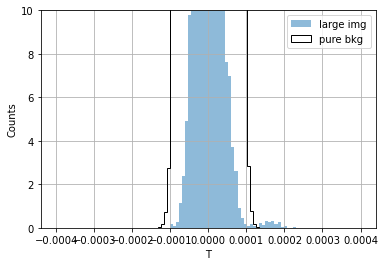

In [88]:
# FFT on planted signals
path2="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/sig_larger/"

PHSsignals = []
for batch in range(1,6):
    temp = np.load(path2+"30_PHS_g1_Sig_onLSS_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

rescale_val = 2
num_select = 1

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(len(selected_evnts)):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)
    
PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)


#hpBkpSig = hpbkgs+PHSsig
qlBkpSig = PHSsig[:,:360,:360]


#hpBkpSigfilt = []
qlBkpSigfilt = []


for evnts in range(500):
    #hptempfft = np.fft.rfft2(hpBkpSig[evnts])
    qltempfft = np.fft.rfft2(qlBkpSig[evnts])
    qltempfft[0,0]=0
    
    fft_power[fft_power<10**-10]=10**20
    #hptempfiltered = np.fft.irfft2(hptempfft    *np_rfft_hk/hpfft_power)
    #qltempfiltered = np.fft.irfft2(qltempfft    * np.conjugate(np_rfft_hk)/qlfft_power)
    qltempfiltered = np.fft.irfft2(qltempfft    * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #hpBkpSigfilt.append(hptempfiltered)
    qlBkpSigfilt.append(qltempfiltered)
    
#hpBkpSigfilt = np.array(hpBkpSigfilt)
qlBkpSigfilt = np.array(qlBkpSigfilt)

#flat_hpBkpSigfilt = hpBkpSigfilt.flatten()
flat_qlBkpSigfilt = qlBkpSigfilt.flatten()

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(flat_qlBkpSigfilt,binsabs,alpha = 0.5,label = "large img",density=True)

n1, bins1, patches1 = plt.hist(flat_qlfiltered_bkg,binsabs,alpha = 1,histtype='step',color = 'black',label = "pure bkg",density=True)

#plt.axvline(binsabs[thres-1],color = 'red',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

plt.ylim(0, 10)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)

In [89]:
evntnum = 6
xloc = PHSsig_loc[evntnum][0,0]
yloc = PHSsig_loc[evntnum][0,1]

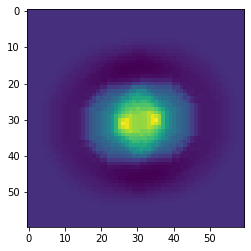

In [90]:
plt.imshow(PHSsig[evntnum][xloc-30:xloc+30,yloc-30:yloc+30])

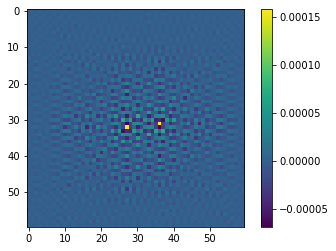

In [91]:
plt.imshow(qlBkpSigfilt[evntnum][xloc-30+25:xloc+30+25,yloc-30+25:yloc+30+25],cmap='viridis')
plt.colorbar()

In [94]:
'''num_select = 25
selected_evnts = []

for tries in range(500):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)
np.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)
'''

'num_select = 25\nselected_evnts = []\n\nfor tries in range(500):\n    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)\n    selected_evnts.append(gen_list[0])\n\nselected_evnts = np.array(selected_evnts)\nnp.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)\n'